# Oura Ring Gen 3: Guide to data extraction and analysis
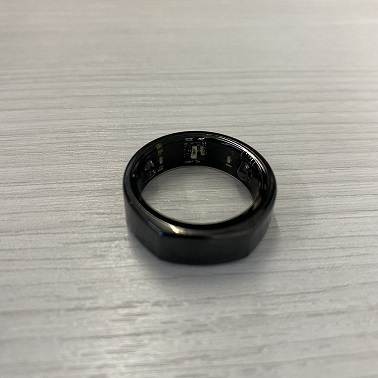

_A picture of the Oura Ring 3 that was used for this notebook_

At **\$299** + **\$5.99** per month and a weight of just 4-6 grams, the [Oura Ring 3](https://support.ouraring.com/hc/en-us/articles/4409072131091-Meet-Gen3) is a unique Sleep and physical activity tracker that, beyond having a price-to-weight ratio higher than gold, has achieved much attention for its ease of use in clinical studies and comfortable wear.

We have used the Oura ring for a month, and we will show you how to extract its data, visualize sleep stages for time and compute correlations and statistical significance from sleep scores to step counts.

This is a comprehensive, clear guide to extract our data from the Oura Ring 3 using the Oura API. Links to external resources and official Oura documentation are provided sporadically throughout the guide for further reference.

If you want to learn more about the Oura ring, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/oura_ring_3) for a detailed analysis of performance, sensors, data privacy, and extraction pipelines.
<br></br>

A list of the most important accessible data categories is provided below, for the full list, access the meta_api_data in section 3.2. The API version is noted in parentheses next to the category name. As of 1/24/25, only the V2 API version is supported.
**The items in bold are the ones we use in the notebook.**

Category Name (API version)| Parameter Name (subcategory)| Frequency of Sampling 
:-------------------:|:----------------------:|:----------------------:
**Heart rate (V2)** | **BPM** | **Every 5 mins**
**Activity (V2)** | **resting time**|**Daily**
Activity (V2) | active calories|Daily 
**Daily activity (V2)** | **equivalent walking distance**|**Daily** 
Activity (V2) | steps |Daily
Activity (V2) | medium activity time |Daily
Activity (V2) | total calories |Daily
Activity (V2) | low activity time |Daily
Activity (V2) | non-wear time |Daily
Activity (V2) | overall score |Daily
Sleep (V2) | awake time |Daily
Sleep (V2) | average breath rate |Daily
**Sleep (V2)** | **REM sleep time** |**Daily**
**Sleep (V2)** | **deep sleep time** |**Daily**
**Sleep (V2)** | **light sleep time** |**Daily**
**Sleep (V2)** | **temperature deviation** |**Daily**
Sleep (V2) | bedtime start |Daily
Sleep (V2)| restless periods |Daily
Sleep (V2)| total sleep duration |Daily
Activity (V2) | score of recovery time |Daily
Activity (V2) | overall score|Daily
Activity (V2) | high activity time|Daily
Activity (V2) | low activity time|Daily
Activity (V2) | total activity time|Daily
Activity (V2) | inactive time|Daily
Activity (V2) | target miles|Daily
Activity (V2) | target calories|Daily
Activity (V2) | training frequency score|Daily
Readiness (V2) | activity balance score |Daily
**Readiness (V2)** | **previous day score**|**Daily**
**Readiness (V2)** | **previous night score** |**Daily**
Readiness (V2) | sleep balance score|Daily
Readiness (V2) | temperature score|Daily 
Ideal bedtimes (V2) | bedtime window|Daily
Sleep (V2) | bedtime end|Daily
**Daily Sleep (V2)** | **overall score**|**Daily**
Daily Sleep (V2) | efficiency|Daily

<br></br>

In this guide, we sequentially cover the following **nine** topics to extract data from the Oura Ring API:

1. **Setup**
    - 1.1: Study participant setup and usage
    - 1.2: Library imports needed to follow through
2. **Authentication and Authorization**
    - 2.1: OAuth(2), allowing access for multiple entities
    - 2.2: Personal access token, intended for personal use
3. **Data Extraction**
    - 3.1: Setting up the parameters to extract the data.
    - 3.2: Extracting data from version 2 endpoints
    - 3.3: Extracting data from version 1 endpoints
    - 3.4: Aggregating the data to be able to easily access it
    - 3.5: Plotting multiple parameters simultaneously
4. **Data Exporting**
    - We export all of this data to file formats
5. **Adherence**
    - We detect when the user isn't using the   device
6. **Visualization**
    - We create a simple plot to visualize our data.
7. **Advanced Visualization**
    - 7.1: Visualizing the different sleep stages
    - 7.2: Visualizing Resting Heart Rate
    - 7.2: Visualizing Body temperature
8. **Outlier Detection and Data Cleaning**
    - We detect outliers in our data and filter them out.
9. **Statistical Data analysis**
    - 9.1: Dispersion analysis between day and night readiness scores.
    - 9.2: We try to find a correlation between equivalent walking distance and the amount of deep sleep. We then find that the correlation is not statistically significant.
    - 9.3: We try to find a correlation between resting time and sleep score. We then find that this correlation is statically significant.

*Note: Full documentation of APIs by Oura can be found [here](https://cloud.ouraring.com/v2/docs) (version 2) and [here](https://cloud.ouraring.com/docs/) (version 1).

# 1. Setup

## 1.1 Study participant setup and usage


## Participant Setup

Dear Participant,

First, download the Oura app from the app store and charge the ring. When the LED blinks blue, the ring is ready to pair. Pair the phone to the ring with Bluetooth and follow the instructions in the app to create your Oura account. You have to spend one night wearing the ring for sleep and readiness score to appear, but the rest of the data will be available immediately. Check [this](https://support.ouraring.com/hc/en-us/articles/4411128662291-Set-Up-an-Oura-Ring) out if you need more info about the setup.

Best,

Wearipedia

## Data Receiver Setup

Please follow the below steps:

1. Create an email address for the participant, for example `foo@email.com`.
2. Create an Oura account with the email `foo@email.com` and some random password.
3. Keep `foo@email.com` and password stored somewhere safe.
4. Distribute the device to the participant and instruct them to follow the participant setup letter above.


To make data available for extraction, you will just need the username and password to generate the API key as illustrated in section 2. Once an API key is generated, these would be no need for the log-in information on the researcher's side.

## 1.2 Library imports

In [ ]:
# Uncomment and Run the following command to install the nessecary libraries locally
# pip install requests matplotlib numpy scipy seaborn pandas

# Relevant libraries are imported below.
# !pip3.11 uninstall -y wearipedia
# !pip3.11 install git+https://github.com/stefren/wearipedia@oura-ring-v2-update

import wearipedia
import requests
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
from matplotlib.patches import FancyBboxPatch

# 2. Authentication and Authorization

To obtain access to data, authentication is required. There are two ways to authenticate, namely:
* [OAuth 2.0](https://cloud.ouraring.com/oauth/applications)


* [Personal Access Token](https://cloud.ouraring.com/personal-access-tokens)

OAuth 2.0 is considered the gold standard. While certainly not [foolproof](https://datatracker.ietf.org/doc/html/draft-ietf-oauth-security-topics), it offers one of the most comprehensive and easily accessible security measures. More information about the OAuth 2.0 protocol is available [here](https://datatracker.ietf.org/doc/html/rfc6749).

Alternatively, Oura also allows for data extraction through Personal Access Tokens (PAT). As a much less secure method, Oura recommends use of PATs for personal use only.

**Clinical use == OAuth 2.0**

*Note: You have to login first to be able to authenticate

## 2.1 OAuth 2.0

OAuth 2.0 can be created by visiting this [link](https://cloud.ouraring.com/oauth/applications) and registering a new application. A couple things to take note of:
* `client_id`: A unique ID required to obtain a code or access token
* `client_secret`: A secret code for added security
* Redirect URIs: `https://127.0.0.1:8080` is also known as the localhost and is where a user can receive a code or token
* Allow server-side authentication/Allow client-side authentication: Allows the user to obtain a code or token

Server-side authorization is more secure but only returns a code, which should then be traded again for a token. Client-side authorization is less secure, but allows users to skip the step of trading the code for a token. For beginners, we recommend utilizing client-side authentication for simplicity.

This is shown below

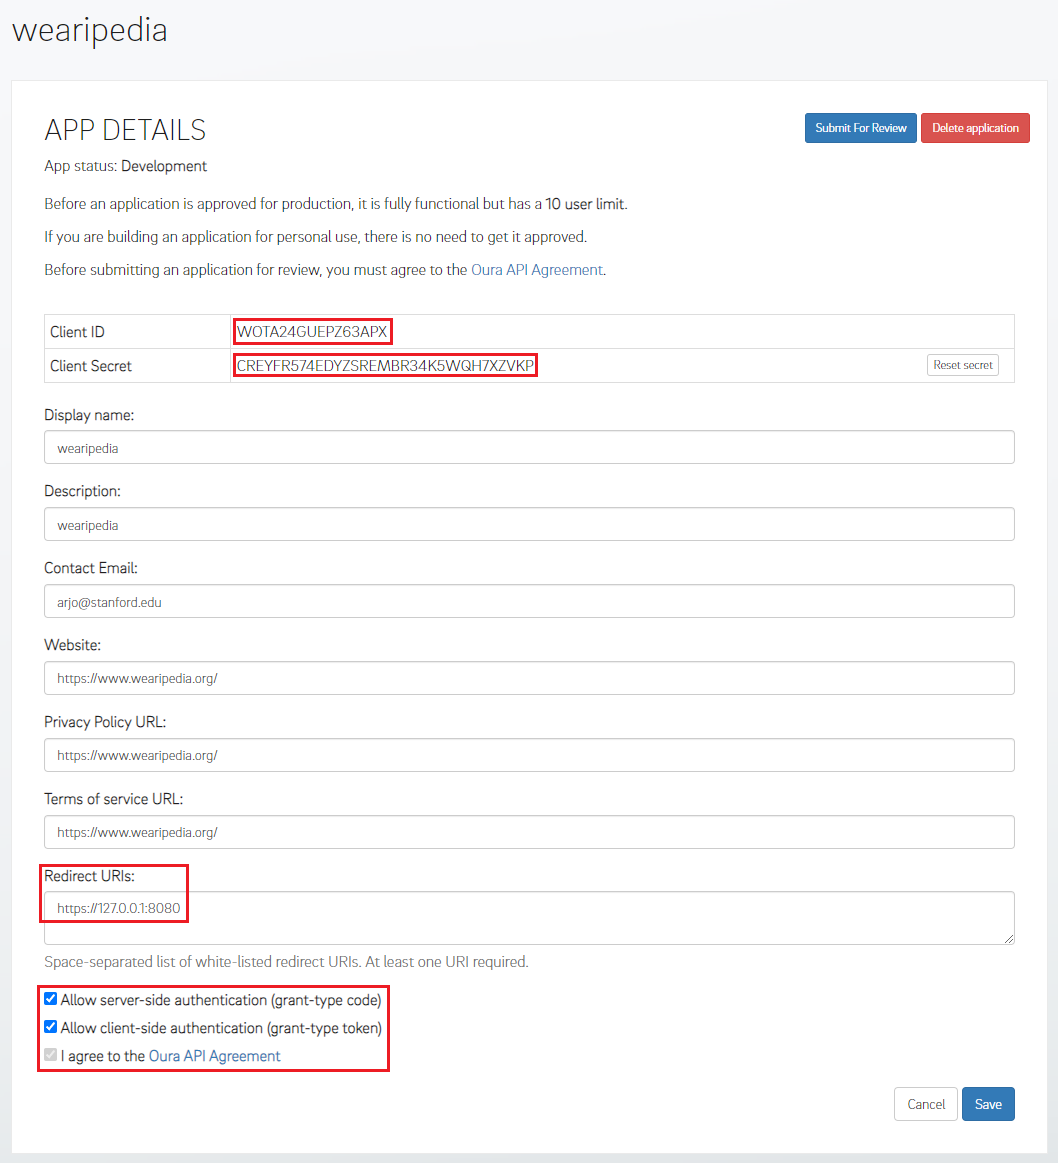



In [ ]:
# We will start storing pertinent parameters into a Python dictionary (`variables`)
variables = dict()

# CHANGE THESE PARAMETERS WITH YOUR OWN ID AND SECRET
variables["client_id"] = "WOTA24GUEPZ63APX"
variables["client_secret"] = "CREYFR574EDYZSREMBR34K5WQH7XZVKP"

# DO NOT CHANGE THESE PARAMETERS
variables["state"] = "XXXX"
variables["redirect_uri"] = "https%3A%2F%2F127.0.0.1%3A8080"
variables["response_type"] = "token"

Afterwards, generate a link with the following code block. Alternatively, a link is provided underneath the APP DETAILS page.

This is shown below

2. Authorization URLs.PNG

In [ ]:
url = "https://cloud.ouraring.com/oauth/authorize"
for key, value in variables.items():
    if url == "https://cloud.ouraring.com/oauth/authorize":
        url += "?" + key + "=" + value
    elif key == "client_secret":
        # exclude client_secret in url for token
        continue
    else:
        url += "&" + key + "=" + value

print(url)

Click on the resulting link above, and click accept. Afterwards, make sure to copy the URL as it provides the access token required to extract data.

This is shown below

3. Authorize.PNG

[link text](https://127.0.0.1:8080/#access_token=7WQF2PVWZVCBZCXKPC2CYJVFRWESWKNQ&token_type=bearer&expires_in=2592000&scope=email%20personal%20daily%20heartrate%20workout%20tag%20session&state=XXX) From this URL, take the combination of letters and numbers after `access_token=` until `&token_type=`. This constitutes the `access_token` required to extract data for this user.

> https://127.0.0.1:8080/#access_token=NZA3DRAHG37X2GDV34YV4Q7XETOKSXKE&token_type=bearer&expires_in=2592000&scope=email%20personal%20daily%20heartrate%20workout%20tag%20session&state=XXXX

In this case, the `access_token` is **7WQF2PVWZVCBZCXKPC2CYJVFRWESWKNQ**. This is added to the `variables` Python dictionary in the code below (hereafter known as `oauth_access_token`).

*Note: This access token will expire in 2592000 seconds, which is one month. If the `oauth_access_token` no longer works due to expiry, please obtain a new `oauth_access_token`.

In [ ]:
#@title Insert Oath access token

token = "" #@param {type:"string"}
variables["oauth_access_token"] = token

## 2.2 Personal Access Token


A personal access token (PAT) is an easy and simple alternative to OAuth 2.0. PATs can be created [here](https://cloud.ouraring.com/personal-access-tokens) and revoked at anytime if tokens are compromised. PATs are visible only at creation and are otherwise hidden from view, save for the first five characters. For privacy reasons, PATs are typically only meant for personal use, and experiments where one entity requires access to multiple entities' data should utilize OAuth 2.0.

This is shown below

4. Personal Access Token.PNG

The `personal_access_token` similarly requires `"Bearer "` in front of the token.

In [ ]:
#@title Insert personal access token

token = "" #@param {type:"string"}
variables["personal_access_token"] = "KPTC7STRLBTZZW3R24ZYSE4KUNYJFYYK" # TODO REMOVE

# 3. Data Extraction
***Note: Documentation, data availability, and function arguments (most likely endpoints) are subject to change.**

Data can be extracted using the Oura Ring API. There is currently only one supported API version, V2. Oura allows users to access data from the categories in section 3.2.


## 3.1 Set Up The Parameters



Here we are going to use the Wearipedia API to handle the Oauth connection. First, we select the start and end dates that we want to extract data from. We can use either `personal_access_token` or `oauth_access_token` depending on which one used in the athentication.

In [ ]:
#@title You can change these parameters
START_DATE = "2025-01-01" #@param {type:"string"}
END_DATE = "2025-01-31" #@param {type:"string"}

# change key to "personal_access_token" if using PAT
TOCKEN_TYPE = "personal_access_token" #@param {type:"string"}
ACCESS_TOKEN = variables[TOCKEN_TYPE]

synthetic = False #@param {type:"boolean"}

In [ ]:
device = wearipedia.get_device("oura/oura_ring3")  # Initialize the device object for the Oura Ring 3

if not synthetic:
  # If the data is not synthetic, authenticate using the access token
  device.authenticate(ACCESS_TOKEN)

# Parameters for retrieving data from the device
params = {"seed": 100, "start_date": START_DATE, "end_date": END_DATE}

# Retrieve data for numerous categories
sleep = device.get_data("sleep", params)
daily_sleep = device.get_data("daily_sleep", params)
daily_activity = device.get_data("daily_activity", params)
ideal_bedtime = device.get_data("ideal_sleep_time", params)
readiness = device.get_data("readiness", params)
heart_rate = device.get_data("heart_rate", params)

# Store the retrieved data in a dictionary
api_data = {}
api_data['sleep'] = sleep
api_data['daily_sleep'] = daily_sleep
api_data['daily_activity'] = daily_activity
api_data['ideal_sleep_time'] = ideal_bedtime
api_data['readiness'] = readiness
api_data['heart_rate'] = heart_rate


# 4. Data Exporting

## Exporting to JSON (R, Matlab, etc.), CSV, and Excell.

In this section, we export all of this data to JSON, which  with popular scientific computing software (R, Matlab).
Exporting to JSON is fairly simple. We export each datatype separately and also export a complete version that includes all simultaneously.

In [ ]:
import json

#@title Select which format to export data!
# set which format you prefer to export
use_JSON = True #@param {type:"boolean"}
use_CSV = True #@param {type:"boolean"}
use_Excel = True #@param {type:"boolean"}

if use_JSON:

  json.dump(api_data["daily_activity"], open("daily_activity.json", "w"))
  json.dump(api_data["sleep"], open("sleep.json", "w"))
  json.dump(api_data["readiness"], open("readiness.json", "w"))
  json.dump(api_data["ideal_sleep_time"], open("ideal_sleep_times.json", "w"))
  json.dump(api_data["heart_rate"], open("heart_rate.json", "w"))

  complete = {
      "daily_activity": api_data["daily_activity"],
      "sleep": api_data["sleep"],
      "readiness": api_data["readiness"],
      "ideal_bedtimes": api_data["ideal_sleep_time"],
  }

  json.dump(complete, open("complete.json", "w"))

if use_CSV:
  pd.DataFrame(api_data["daily_activity"]).to_csv("daily_activity.csv", index=False)
  pd.DataFrame(api_data["sleep"]).to_csv("sleep.csv", index=False)
  pd.DataFrame(api_data["readiness"]).to_csv("readiness.csv", index=False)
  pd.DataFrame(api_data["ideal_sleep_time"]).to_csv("ideal_sleep_time.csv", index=False)
  pd.DataFrame(api_data["heart_rate"]).to_csv("heart_rate.csv", index=False)

if use_Excel:
  pd.DataFrame(api_data["daily_activity"]).to_excel("daily_activity.xlsx", index=False)
  pd.DataFrame(api_data["sleep"]).to_excel("sleep.xlsx", index=False)
  pd.DataFrame(api_data["readiness"]).to_excel("readiness.xlsx", index=False)
  pd.DataFrame(api_data["ideal_sleep_time"]).to_excel("ideal_sleep_time.xlsx", index=False)
  pd.DataFrame(api_data["heart_rate"]).to_excel("heart_rate.xlsx", index=False)



# 5. Adherence

In this section, we will simulate non-adherence over longer periods of time from the participant (day-level and week-level). We will first delete chunks of data, given user input, and then visualize user non-adherence.

In [ ]:
#@title 5.1 Non-adherence simulation and detection
import random as random

block_level = "day" #@param ["day", "week"]
daily_activity_nonadherence_percent = 0.25 #@param {type:"slider", min:0, max:1, step:0.01}
sleep_nonadherence_percent = 0.24 #@param {type:"slider", min:0, max:1, step:0.01}
activity_nonadherence_percent = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}
readiness_nonadherence_percent = 0.37 #@param {type:"slider", min:0, max:1, step:0.01}
ideal_bedtime_nonadherence_percent = 0.23 #@param {type:"slider", min:0, max:1, step:0.01}

detect_adherence_only = False #@param {type:"boolean"}


def remove_entries(data, percent):
    """
    Removes a percentage of entries from a list of lists.

    :param data: list of lists representing the entries to be processed
    :param percent: float representing the percentage of entries to be removed
    :return: list of lists representing the remaining entries after removal
    """
    num_entries = len(data)
    num_entries_to_keep = int(percent * num_entries)
    idxes_to_keep = np.random.choice(np.arange(num_entries), replace=False, size=num_entries_to_keep)
    return [data[i] for i in idxes_to_keep]

sleep_adherence = remove_entries(api_data['sleep'], sleep_nonadherence_percent)
daily_activity_adherence = remove_entries(api_data['daily_activity'], daily_activity_nonadherence_percent)
ideal_bedtime_adherence = remove_entries(api_data['ideal_sleep_time'], ideal_bedtime_nonadherence_percent)
readiness_adherence = remove_entries(api_data['readiness'], readiness_nonadherence_percent)

if not detect_adherence_only:
    if block_level == "day":
        block_length = 1
    elif block_level == "week":
        block_length = 7

    sleep_num_blocks_to_keep = int((1 - sleep_nonadherence_percent) * len(api_data['sleep']))
    daily_activity_num_blocks_to_keep = int((1 - daily_activity_nonadherence_percent) * len(api_data['sleep']))
    readiness_num_blocks_to_keep = int((1 - readiness_nonadherence_percent) * len(api_data['sleep']))
    ideal_bedtime_num_blocks_to_keep = int((1 - ideal_bedtime_nonadherence_percent) * len(api_data['sleep']))
    # heart_rate_num_blocks_to_keep = int((1 - hr_nonadherence_percent) * len(api_data['sleep']))

    sleep_idxes = np.random.choice(np.arange(len(api_data['sleep'])), replace=False, size=sleep_num_blocks_to_keep)
    sleep_adherence = [api_data['sleep'][i] for i in sleep_idxes]
    api_data['sleep'] = sleep_adherence

    daily_activity_idxes = np.random.choice(np.arange(len(api_data['daily_activity'])), replace=False, size=daily_activity_num_blocks_to_keep)
    daily_activity_adherence = [api_data['daily_activity'][i] for i in daily_activity_idxes]
    api_data['daily_activity'] = daily_activity_adherence

    readiness_idxes = np.random.choice(np.arange(len(api_data['readiness'])), replace=False, size=readiness_num_blocks_to_keep)
    readiness_adherence = [api_data['readiness'][i] for i in readiness_idxes]
    api_data['readiness'] = readiness_adherence

    ideal_bedtime_idxes = np.random.choice(np.arange(len(api_data['ideal_sleep_time'])), replace=False, size=ideal_bedtime_num_blocks_to_keep)
    ideal_bedtime_adherence = [api_data['ideal_sleep_time'][i] for i in ideal_bedtime_idxes]
    api_data['ideal_sleep_time'] = ideal_bedtime_adherence


## 5.2 Visualizing non-wear measured by Oura

We are going to see how much time was the Oura Ring wasn't worn here. First, we gather the non-wear time and dates and place them in separate arrays. Then we create a simple bar plot and make it visually appealing using seaborn library.

In [ ]:
arr1 = []
arr2 = []
for metric in api_data["daily_activity"]:
    arr1.append(metric['day'])
    arr2.append(metric['non_wear_time'])

d = {'Non Wear Time (mins)': arr2, 'Date': arr1}
df = pd.DataFrame(data=d)
df = df.sort_values('Date')


sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Non Wear Time (mins)", y="Date", data=df)

# 6. Visualization

> 
Let's overlay medium activity time, REM sleep time, resting time, and non-wear time, all in one plot and investigate the trends among them. It is possible because they are all represented the amount of time spended in each activity.
We represent each parameter with a different graph color that is illustrated in the graph's legend.


In [ ]:
import datetime

# first we get those arrays for the wanted parameters
arr_medium = []
arr_rem = []
arr_nonwear = []
arr_resting = []
arr_date = []

smoothness = 0.14 #@param {type:"slider", min:0, max:1, step:0.01}
sigma = 10 * smoothness

# Make sure the values plotted correspond to the same days, since sometimes the ring
# skips certain data of some days, maybe because the user disabled it

First_DATE = "2025-01-01" #@param {type:"string"}
Last_DATE = "2025-01-31" #@param {type:"string"}

first_date = datetime.datetime.strptime(First_DATE, "%Y-%m-%d")
last_date = datetime.datetime.strptime(Last_DATE, "%Y-%m-%d")

hmap = {}
for metric in api_data["sleep"]:
    date = datetime.datetime.strptime(metric["day"], "%Y-%m-%d")
    if first_date <= date <= last_date:
        hmap[metric["day"]] = metric["rem_sleep_duration"]

for metric in api_data['daily_activity']:
    if metric['day'] in hmap:
        arr_medium.append(metric['medium_activity_time']//60)
        arr_nonwear.append(metric['non_wear_time']//60)
        arr_resting.append(metric['resting_time']//60)
        arr_rem.append(hmap[metric['day']]//60)
        arr_date.append(metric['day'][5:10])
print(arr_medium, arr_rem, arr_nonwear, arr_resting)
arr_medium = list(gaussian_filter(arr_medium, sigma=sigma))
arr_nonwear = list(gaussian_filter(arr_nonwear, sigma=sigma))
arr_resting = list(gaussian_filter(arr_resting, sigma=sigma))
arr_rem = list(gaussian_filter(arr_rem, sigma=sigma))


#creating the plots with the legends
plt.xlabel('Day')
plt.ylabel('Time (mins)')
sns.lineplot(x = arr_date, y = arr_medium, color = 'g', legend = 'auto', label = 'Medium Activity Time')
sns.lineplot(x = arr_date, y = arr_rem, color = 'r', legend = 'auto', label = 'Rem Sleep Time')
sns.lineplot(x = arr_date, y = arr_resting, color = 'b', legend = 'auto', label = 'Resting Time')
sns.lineplot(x = arr_date, y = arr_nonwear, color = 'y', legend = 'auto', label = 'Non-wear Time')

#using seaborn library to make the graph look better

width_w = 300
height_t = 30

sns.set(context='notebook', style='darkgrid', font='sans-serif', font_scale=1.2, color_codes=True, rc={'figure.figsize':(11, 8)})

# Custom color palette
custom_palette = sns.color_palette("viridis", as_cmap=True)

# Show legend
plt.legend()

# Show the plot
plt.show(block=True)

#plotting outliers with a different color
plt.show(block=True)


# 7. Advanced Visualization

## 7.1 Sleep Stages Visualization

When using the Oura app, the user has access to their sleep history as a plot under the sleep tab. The stages of sleep are delineated and the amount of time under each sleep stage can be visualized on a daily basis (shown below).
<br></br>
Oura Sleep on App.PNG
<br></br>
In the above plot, we've recreated a plot using `matplotlib` and extracting sleep parameters from the Oura device.

Oura stacks different sleep stages on top of one-another. From the bottom, the plot shows **Deep Sleep**, followed by **Light Sleep**, **REM Sleep**, and **Time Awake**. When stacked on top of one another, it gives a visual overview of the sleep quality and time spent slept (Deep + Light + REM).

To create the plot, first, we extract our data of interest, the amount of deep sleep, light sleep, rem sleep, awake time, and the dates from api_data dictionary into separate arrays. Then we will use `matplotlib`'s `pyplots` library on [stackplot](https://matplotlib.org/stable/gallery/lines_bars_and_markers/stackplot_demo.html#sphx-glr-gallery-lines-bars-and-markers-stackplot-demo-py). The stackplot allows us to represent the different sleep stages, including the awake state, stacked on top of each other. After this, we adjust the aesthetic components of the plot to make it look like the original.

In [ ]:
from re import T
"""
1. Extract the parameters of interest from our api call
    - api_data is a list of daily logs
    - looping over api_data will store daily sleep parameters in separate lists
"""

#@title Enter the date you want the analysis for
ANALYSIS_DATE = '2025-01-03' #@param {type:"string"}
DATE_TITLE = 'Friday, Jan 3rd'

deep, light, rem, awake, dates = [], [], [], [], []
currentDate = api_data['sleep'][0]['day']
deep_sleep_duration, light_sleep_duration, rem_sleep_duration, awake_time = 0, 0, 0, 0
sortedSleepData = sorted(api_data['sleep'], key=lambda x: x['day'])
for elem in sortedSleepData:
    if currentDate != elem['day']:
        deep.append(deep_sleep_duration/ 60 / 60)  # sec -> min -> hour
        light.append(light_sleep_duration / 60 / 60)
        rem.append(rem_sleep_duration / 60 / 60)
        awake.append(awake_time / 60 / 60)
        dates.append(elem['day'])
        deep_sleep_duration, light_sleep_duration, rem_sleep_duration, awake_time = 0, 0, 0, 0
        currentDate = elem['day']
    deep_sleep_duration += elem['deep_sleep_duration']
    light_sleep_duration += elem['light_sleep_duration']
    rem_sleep_duration += elem['rem_sleep_duration']
    awake_time += elem['awake_time']

# put data into a dictionary for the stackplot function below
sleepData ={
    'Deep': deep,
    'Light': light,
    'REM': rem,
    'Awake': awake
}
start_date = dates[0]
end_date = dates[-1]

"""
2. Plot stackplot with matplotlib
"""
# set style to dark
plt.style.use('dark_background')

# define colors for Deep, Light, REM, Awake
color_map = ["#2c4677", "#568bbd", "#85c9fa", "#f2f3f5"]

# setup and plot
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
plt.rc('font', size=22)
ax.stackplot(dates, sleepData.values(),
             labels=sleepData.keys(), colors=color_map, alpha=0.8, edgecolor='none')

# removing the borders from four sides
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


#remove x and y tics
plt.xticks([])
plt.yticks([])

#set a new order for handles and lables
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]

# set legend below plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper center', bbox_to_anchor=(0.5, 0.26),
          fancybox=True, shadow=True, ncol=5, fontsize= 18, frameon=False, handlelength=0.9)
ax.set_title(DATE_TITLE, color = '#85c9fa')


#getting total sleep and time in bed for march 24th
total_in_bed = 0
total_sleep = 0
for metric in api_data["sleep"]:
    if metric['day'] == ANALYSIS_DATE:
        total_in_bed += metric['time_in_bed']
        total_sleep += metric['total_sleep_duration']


# try:
#get hours and minutes separated
totalinbed_h = total_in_bed // 60 // 60  #convert to hours
totalinbed_m = (total_in_bed // 60) - (totalinbed_h * 60) #see how many mins left



totalsleep_h = total_sleep // 60 // 60
totalsleep_m = (total_sleep // 60) - (totalsleep_h * 60)

# updated strings
inbed_h_m = str(totalinbed_h) + "h "+ str(totalinbed_m) + 'm'
sleep_h_m = str(totalsleep_h) + "h "+ str(totalsleep_m) + 'm'

#adding the total sleep and time in bed
plt.figtext(0.3,0,'Total sleep', fontsize=18, ha='center', color ='#959caa', fontweight = 'bold')
plt.figtext(0.72,0,'Time in bed', fontsize=18, ha='center', color ='#959caa', fontweight = 'bold')
plt.figtext(0.3,-0.15,sleep_h_m, fontsize=24, ha='center', color ='w', fontweight = 'bold')
plt.figtext(0.72,-0.15,inbed_h_m, fontsize=24, ha='center', color ='w', fontweight = 'bold')

#create the horizontal lines for the legend to make the spacing look right
line = plt.Line2D((-1, 9), (-0.1, -0.1), lw=1.3, color='black')
line2 = plt.Line2D((-1, 9), (-3, -3), lw=1.3, color='black')
plt.gca().add_line(line)
plt.gca().add_line(line2)

plt.plot([], [], color='black', label='Line 1')
plt.plot([], [], color='black', label='Line 2')

plt.subplots_adjust(hspace = 0, wspace=0)

plt.show()

# except:
#   print("Date not in the data. Change adherence or try another date")

## 7.2 Visualizing Resting Heart Rate

Next, we will try can recreate the resting heart rate plot found in the Oura Ring app. The heart rate measured during sleep is visualized and represented in the plot. First, we gather the wake and sleep times and format them. Then, we collect the heart rates and the times at which they were recorded from the api_data dictionary. After this, we plot the graph and edit its aesthetic aspects. Finally, we place labels at the top of the sleep time and the waking up time.

Here is the visual we are trying to replicate from the app.

resting heartrate.png

In [ ]:
the_date = "2025-01-03" #@param {type:"date"}

#protecting against dates with no data
try:
  # first we get the bed time and waking up time from the sleep data
  for metric in api_data["sleep"]:
      if metric['day'] == the_date:
          start_time = metric['bedtime_start'][11:19].replace(":","")
          start_in_hours = float((start_time)[:2]) + float((start_time)[2:4]) / 60 + float((start_time)[4:6]) / 3600

          end_time = metric['bedtime_end'][11:19].replace(":","")
          end_in_hours = float((end_time)[:2]) + float((end_time)[2:4]) / 60 + float((end_time)[4:6]) / 3600
          break


  with plt.style.context('dark_background'):

  # getting the bpm and the time stamp of the given date
      bpm, timestamp = [], []
      for elem in api_data['heart_rate']:
          # Here we get the date from the timestamp
          date_temp = elem['timestamp'][0:10]

          # checking for entries with the desired date
          if date_temp == the_date:
              # getting times from timestamp
              time_temp = elem['timestamp'][11:19]
              time_string = time_temp.replace(":","")
              # converting the times to hours
              time_hours = float((time_string)[:2]) + float((time_string)[2:4]) / 60 + float((time_string)[4:6]) / 3600
              timestamp.append(time_hours)
              bpm.append(elem['bpm'])
      # smoothing the data for visualization
      filtered_data = gaussian_filter(timestamp, sigma=3)

      # creating the plot and setting the background color
      fig = plt.figure(figsize=(4,3))
      fig.patch.set_facecolor('#171b1e')

      #getting the average bpm
      av = sum(bpm)/len(bpm)
      #creating an average line
      plt.axhline(y=av, dashes = (2,5), linewidth = 0.5)

      plt.plot(filtered_data, bpm, linewidth=1, color='#07c8d8')


      # setting the x labels
      times = [22,2,6,10,14,18,22]
      plt.xticks(ticks=times, labels=['10pm', '2am', '6am', '10am', '2pm', '6pm','10pm'], color = "#A7AFB2", fontsize=8)

      #setting the minor ticks as the sleep time and the wake up time
      start_and_end = [start_in_hours, end_in_hours]
      plt.gca().set_xticks(ticks = start_and_end, minor=True)

      # adjusting the label size
      plt.tick_params(axis='x', labelsize=8)
      plt.tick_params(axis='y', labelsize=8)

      # removing the borders from four sides
      plt.gca().spines['left'].set_visible(False)
      plt.gca().spines['right'].set_visible(False)
      plt.gca().spines['top'].set_visible(False)
      plt.gca().spines['bottom'].set_visible(False)

      # change the y-labels to the right side
      plt.gca().yaxis.tick_right()

      #remove the tic dashes
      plt.gca().yaxis.set_tick_params(length=0,labelbottom=False)

      # set the colors of the grid
      plt.gca().grid(axis='y', color='#383838', dashes = (8,5))
      plt.gca().grid(axis='x', which = "major", visible = False)
      plt.gca().grid(axis='x', which = "minor", color = '#383838')

      # place a title on the graph
      plt.figtext(0.52,1,'Resting heart rate', fontsize=14, ha='center', color ='#A7AFB2', fontweight=0)

      # adjust the facecolor
      plt.gca().set_facecolor('#171b1e')

      #increase the limits of the yaxis
      plt.ylim(top=200)
      plt.ylim(bottom=40)

      #keeping on only some of the y values by adjusting the labels
      bpms = [60, 100, 140, 180]
      plt.yticks(ticks=bpms, labels=['60', '100', '140','180'], color = "#A7AFB2", fontsize=8)

      #placing the labels on the vertical bars
      #first convert to the hours and minutes format
      start_hours = int(start_in_hours)
      start_mins = int((start_in_hours - start_hours) * 60)
      end_hours = int(end_in_hours)
      end_mins = int((end_in_hours - end_hours) * 60)

      #formating the minutes
      if start_mins < 10:
          start_mins = '0'+ str(start_mins)
      else:
          start_mins = str(start_mins)

      if end_mins < 10:
          end_mins = '0'+ str(end_mins)
      else:
          end_mins = str(end_mins)

      #convert to 12_hour system and prepare the labels
      if start_hours == 0:
          startlabel = "12" + ":" + (start_mins) + " am"
      elif start_hours < 12:
          startlabel = str(start_hours) + ":" + (start_mins) + " am"
      elif start_hours == 12:
          startlabel = "12" + ":" + (start_mins) + " pm"
      else:
          startlabel = str(start_hours-12) + ":" + (start_mins) + " pm"

      if end_hours == 0:
          endlabel = "12" + ":" + (end_mins) + " am"
      elif end_hours < 12:
          endlabel = str(end_hours) + ":" + (end_mins) + " am"
      elif end_hours == 12:
          endlabel = "12" + ":" + (end_mins) + " pm"
      else:
          endlabel = str(end_hours-12) + ":" + (end_mins) + " pm"



      #notice that the graph spans from 0.15 to 0.9 which makes
      #the range equal to 0.75 so we place the label in its
      #right location relative to this range
      plt.figtext(0.15+((start_in_hours/24)*0.75), 0.9,startlabel, fontsize=8, ha='center', color ='#A7AFB2', fontweight = 'bold')
      plt.figtext(0.15+((end_in_hours/24)*0.75), 0.9,endlabel, fontsize=8, ha='center', color ='#A7AFB2', fontweight = 'bold')


      plt.show(block=True)
except Exception as e:
    print(e)
    print('Data at this date is distorted, set non-adherence to zero')


It looks like we were able to replicate the main elements of the plot with matplotlib!

## 7.3 Visualizing Body temperature  

Here is another visualization from the Oura app that we will try to replicate. The plot visualizes body temperature changes over the given range of dates.
To create this plot, first we extract the temperature_delta data and the dates from the the api_data dictionary and save them in separate arrays. After this we create a bar graph, adjust the aesthetic elements to make it look like the original. We finally make the bars have rounded corners, and voila!


body temp.png

In [ ]:
bar_width = 0.42 #@param {type:"slider", min:0, max:1, step:0.01}


with plt.style.context('dark_background'):

    temperature_delta, summary_date = [], []

    for elem in sortedSleepData:
        if elem["readiness"].get("temperature_deviation") is not None:
            temperature_delta.append(elem["readiness"]["temperature_deviation"])
            summary_date.append(elem['day'])
            
    fig,ax = plt.subplots()

    fig.set_size_inches(6, 6)
    
    all_dates = pd.date_range(start=min(summary_date), end=max(summary_date), freq='D')
    all_dates_str = [date.strftime('%Y-%m-%d') for date in all_dates]
    
    # Create a mapping of existing values
    values_dict = dict(zip(summary_date, temperature_delta))
    
    # Create complete series with NaN for missing dates
    complete_temps = [values_dict.get(date, np.nan) for date in all_dates_str]

    # bar graph
    plt.bar(all_dates_str, complete_temps, color = '#96c146', width = bar_width)

    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)

    #removing the borders
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    #make the y tics on the right
    plt.gca().yaxis.tick_right()

    #change the colors of the grid
    plt.gca().grid(axis='y', color='#1d2021', dashes = (8,5))
    plt.gca().grid(axis='x', color='#1d2021')


    #remove the tic dashes
    ax.yaxis.set_tick_params(length=0,labelbottom=False)

    #put a title
    plt.title("Body Temperature", fontsize=15,fontweight = 'bold', color = "#A7AFB2")

    # making the graph roundish like. from https://stackoverflow.com/questions/58425392/bar-chart-with-rounded-corners-in-matplotlib
    new_patches = []
    for patch in reversed(ax.patches):
        bb = patch.get_bbox()
        color=patch.get_facecolor()
        p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.0040,rounding_size=0.015",
                        ec="none", fc=color)
        patch.remove()
        new_patches.append(p_bbox)
    for patch in new_patches:
        ax.add_patch(patch)

    #remove x tics
    plt.xticks([])

    #increase the limits of the yaxis
    plt.ylim(top=3)
    plt.ylim(bottom=-1.5)

    plt.show(block=True)


# 8. Outlier Detection and Data Cleaning



We find outliers and remove them in order to get better analysis accuracy by removing the possibility of measurement errors, but at the same time it can affect the result's accuracy since some outliers are true outliers: outliers that is important in the data itelf. Check [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7485938) out to learn more about the effects of removing outliers.

There are multiple ways of annotating outliers. According to the [National Institute of Standards and Technology's handbook](https://https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm#:~:text=An%20outlier%20is%20an%20observation,what%20will%20be%20considered%20abnormal.). We assume that a "mild outlier" is a datapoint that is higher than or lower than the first quartile or higher than the third quartile by a distance of the interquartile range multiplied by 1.5 points, while "extreme outliers" are ones that distance multipled by 3 points instead.



In [ ]:
def calc_interquantile(category_name, sub_Category_Name):
    # create an array with the data
    arr1 = []
    for metric in api_data[category_name]:
        arr1.append(metric[sub_Category_Name])

    # add an outlier data for testing (relevant to sleep data)
    arr1.append(20000)

    #find interquartile range
    quartiles = numpy.quantile(arr1, [0.25,0.75])
    q1, q3 = quartiles[0],quartiles[1]
    interquartile_Range = q3 - q1

    #append outliers
    outliers = []
    for item in arr1:
        if item >= q3+(1.5* interquartile_Range) or item <= q1 - (1.5*interquartile_Range):
            outliers.append(item)
    return outliers

In [ ]:
# testing with the sleep data
list_Of_Outliers = calc_interquantile("sleep", "rem_sleep_duration")
print(list_Of_Outliers)

An alternative way is to use the Z-scores of the data points. Since z-scores represent how many standard deviations away a given observation is from the mean. For example, a Z-score of 2.5 means that the data point is 2.5 standard deviations from the mean.

An arbitrary threshold is usually used in order to detect outliers. In this example, I used 2 and -2 as the thresholds, but you can change that. Usually 3,-3 are the standard cut-off. However, these are somewhat arbitrary can be changed. Check chapters 2.2 and 2.3 [here](http://etheses.dur.ac.uk/2432/1/2432_443.pdf) to learn more.

In [ ]:
def calc_z_score(category_name, sub_Category_Name):
    arr1 = []
    for metric in api_data[category_name]:
        arr1.append(metric[sub_Category_Name])

    # add an outlier data for testing (relevant to sleep data)
    arr1.append(22000)

    #find z-scores
    z_scores_array = stats.zscore(arr1)

    #add outliers
    outliers = []
    i = 0

    Upper_Threshold = 2 #@param {type:"integer"}
    Lower_Threshold = -2 #@param {type:"integer"}

    for i in range(len(z_scores_array)):
        if z_scores_array[i] >= Upper_Threshold or z_scores_array[i] <= Lower_Threshold: # you can change the threshold here
            outliers.append(arr1[i])
    return outliers

In [ ]:
# testing with the sleep data
list_Of_Outliers = calc_z_score("sleep", "rem_sleep_duration")
print(list_Of_Outliers)

Now lets plot the REM data with outlier(s) highlighted in a different color.

In [ ]:
arr1 = []
for metric in api_data["sleep"]:
    arr1.append(metric["rem_sleep_duration"])

# add an outlier data for testing (relevant to sleep data)
arr1.append(22000)

#creating an array for day numbers.
arr2 = []
for i in range(len(arr1)):
    arr2.append(i)

#Creating a dataframe with the arrays
d = {'Rem sleep time': arr1, 'Day #': arr2}
df = pd.DataFrame(data=d)

#Detecting the outliers
list_Of_Outliers = calc_z_score("sleep", "rem_sleep_duration")

#creting a list of days that correspond to the outlier values in rem sleep
outlier_days = []
for i in range(len(arr2)):
    if arr1[i] in list_Of_Outliers:
        outlier_days.append(arr2[i])
# Set the style to whitegrid
sns.set_style("whitegrid")

# Create the first plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Day #', y='Rem sleep time', data=df, color='b')
plt.title('Rem Sleep Time Over Days')
plt.xlabel('Day #')
plt.ylabel('Rem Sleep Time')

# Create the second plot without highlighting the outlier
plt.subplot(1, 2, 2)
sns.scatterplot(x='Day #', y='Rem sleep time', data=df, color='b')
sns.scatterplot(x=outlier_days, y=list_Of_Outliers, color='r', s=100, label='Outlier (Z-value > 2)')
plt.title('REM Data with Outliers Highlighted')
plt.xlabel('Day #')
plt.ylabel('Rem Sleep Time')
plt.legend()
plt.tight_layout()

plt.show()

Here appears the injected datapoint in red since it was detected as an outlier

# 9. Statistical Data Analysis

**(Note that the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.)**

## 9.1 Dispersion analysis between day and night readiness scores

Readiness reflects your body's preparedness for optimal performance, calculated from factors like sleep quality and activity levels. Nighttime readiness is based on sleep, while daytime readiness considers activity and recovery. You can learn more about readiness scores here: https://ouraring.com/blog/readiness-score/.

Statistical dispersion is a measure of how spread out a set of data points is. It can show how much the data varies across entries, and it becomes useful in the cases of large datasets where we need to know if the data entry varies more in case A or case B. In this case we are checking whether readiness score has higher dispersion (varies more) during day or at night.

Dispersion has multiple ways of representation. One of them, according to [The National Institute of Statistics and Economic Studies](https://https://www.insee.fr/en/metadonnees/definition/c1366#:~:text=The%20coefficient%20of%20variation%20(CV,generally%20expressed%20as%20a%20percentage.) is the coefficient of variance, also called the relative standard deviation, which is the standard deviation divided by the mean of the set of values.

Hypothesis:

**Null Hypothesis (H0)**: The dispersion of readiness scores is the same during the day and night.

**Alternative Hypothesis (H1)**: There is a significant difference in the dispersion of readiness scores between day and night.

Methodology:

We will employ a statistical test to compare the coefficients of variance (CV) between day and night readiness scores. The CV is calculated as the standard deviation divided by the mean.

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Prepare the data
arr_Day, arr_Night = [], []
for metric in api_data["readiness"]:
    if metric['contributors']['previous_day_activity'] is not None and metric['contributors']['previous_night'] is not None:
        arr_Day.append(metric["contributors"]["previous_day_activity"])
        arr_Night.append(metric["contributors"]["previous_night"])

# Calculate standard deviation and mean
std_deviation_day = np.std(arr_Day)
std_deviation_night = np.std(arr_Night)
mean_day = np.mean(arr_Day)
mean_night = np.mean(arr_Night)

# Calculate variance coefficient
variability_coefficient_day = std_deviation_day / mean_day
variability_coefficient_night = std_deviation_night / mean_night

# Perform two-sample t-test
t_statistic, p_value = ttest_ind(arr_Day, arr_Night)

# Set significance level
alpha = 0.05

# Compare p-value to significance level
if p_value < alpha:
    print('There is a significant difference in dispersion between day and night.')
    if variability_coefficient_day > variability_coefficient_night:
        print('Day data variability is higher')
    else:
        print('Night data variability is higher')
else:
    print('There is no significant difference in dispersion between day and night.')

Now lets have a visual representation of this

In [ ]:
# Prepare the dataframe
d = {'day score': arr_Day, 'night score': arr_Night}
df = pd.DataFrame(data=d)

# Create a relplot
graph = sns.relplot(data=df, y="day score", x="night score")

# Add scatter plot and legend
graph.map(plt.scatter, "night score", "day score", color="black", edgecolor="w").add_legend()

# Set the style
with sns.axes_style("dark"):
    sns.set_context("notebook", font_scale=1, rc={"font.sans-serif": ["Arial", "Helvetica"]})
    # Show the plot
    plt.show(block=True)


This finds no significant difference in dispersion between day and night readiness scores, it suggests that the variability in scores remains consistent regardless of the time of day.

## 9.2  Correlation between equivalent walking distance and the amount of deep sleep



Let's perform some more analysis on the data trying to find correlations between different data categories that may be statistically significant relationship. The first hypothesis that comes to mind is that exercise throughout the day may somehow have a correlation with the amount of deep sleep the person gets at night. Let's see if this is true.



### Hypothesis:

**Null Hypothesis (H0)**: There is no correlation between the frequency of daily exercise and the amount of deep sleep obtained at night.

**Alternate Hypothesis (H1)**: A significant correlation exists between the frequency of daily exercise and the amount of deep sleep obtained at night.

### Methodology:

To test this, we will use Pearson's correlation coefficient. It helps measure any potential link, be it positive or negative, between daily exercise frequency and the amount of deep sleep. The null hypothesis assumes no significant correlation, while the alternative hypothesis suggests the presence of a meaningful connection. Through this analysis, we aim to explore if daily exercise is associated with the quality of nocturnal deep sleep.


In [ ]:
# First identify the outliers to remove them
sleep_Outliers = calc_z_score("sleep", "deep_sleep_duration")
walking_distance_outliers = calc_z_score("daily_activity", "equivalent_walking_distance")

# Make sure the values plotted correspond to the same days, since sometimes the ring
# skips certain data of some days, maybe because the user disabled it
hmap = {}
for metric in api_data["daily_activity"]:
    hmap[metric["day"]] = metric["equivalent_walking_distance"]

arr1 = []
arr2 = []
for metric in api_data["sleep"]:
    if metric["day"] in hmap:
        # remove the outliers
        if metric["deep_sleep_duration"] not in sleep_Outliers and hmap[metric["day"]] not in walking_distance_outliers:
            arr1.append(metric["deep_sleep_duration"]/3600) #converting to hours
            arr2.append(hmap[metric["day"]])

# plot the data
d = {'deep sleep (hours)': arr1, 'walking distance (steps)': arr2}
df = pd.DataFrame(data=d)

graph = sns.lmplot(data=df, y="deep sleep (hours)", x="walking distance (steps)")

graph.map(plt.scatter, "walking distance (steps)", "deep sleep (hours)", color="black").add_legend()
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=1, color_codes=True)

plt.show(block=True)


Now lets test the null hypothesis that amount of deep sleep does not increase as the distance walked increases. Looks like there is a small trend here, and a critic might argue that it could result from chance. To test this claim, which is that the null hypothesis is indeed false, we perform the Wald test, which addresses this setting precisely.



In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(arr1,arr2)
print(p_value)

But it appears that it is statistically insignificant since it is >0.05,
since there is a 39% chance this data may have occured by chance. So this isn't significant result and we can thus do not reject the null hypothesis  that amount of deep sleep does not increase as the distance walked increases

## 9.3 Correlation between resting time and sleep score  

Here is a different hyptotheisis that the amount of resting time during the day has a correlation between the sleep overall score which represents its quality.
With a few changes to the code, we can test for this hypothesis.


### Hypothesis:

**Null Hypothesis (H0)**: The amount of resting time during the day is not correlated with the overall sleep score; there is no significant linear relationship between these variables.

**Alternative Hypothesis (H1)**: There exists a significant correlation between the amount of resting time during the day and the overall sleep score, indicating a discernible linear relationship.


### Methodology:

To test this hypothesis, we will conduct a correlation analysis using Pearson's correlation coefficient. This statistical method will quantify the strength and direction of any linear relationship between daytime resting time and overall sleep quality. Through this approach, we aim to determine if there is a significant correlation between these variables.


In [ ]:
# First identify the outliers to remove them
sleep_Outliers = calc_z_score("daily_sleep", "score")
resting_time_outliers = calc_z_score("daily_activity", "resting_time")

# Make sure the values plotted correspond to the same days, since sometimes the ring
# skips certain data of some days, maybe because the user disabled it
hmap = {}
for metric in api_data["daily_activity"]:
    hmap[metric["day"]] = metric["resting_time"]

arr1 = []
arr2 = []
for metric in api_data["daily_sleep"]:
    if metric["day"] in hmap:
        # remove the outliers
        if metric["score"] not in sleep_Outliers and hmap[metric["day"]] not in resting_time_outliers:
            arr1.append(metric["score"])
            arr2.append(hmap[metric["day"]]/3600) #converting to hours

# plot the data
d = {'sleep score': arr1, 'resting time(hours)': arr2}
df = pd.DataFrame(data=d)
graph = sns.lmplot(data=df, y="sleep score", x="resting time(hours)")
graph.map(plt.scatter, "resting time(hours)","sleep score", edgecolor ="w").add_legend()
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=1, color_codes=True)

plt.show(block=True)

Now lets test the null hypothesis that sleep score doesn't increase as resting time increases. Looks like there is indeed a trend here. To provide strong quantitative evidence in favor of our claim, which is that the null hypothesis is indeed false, we perform the Wald test, which addresses this setting precisely.


In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(arr1,arr2)
print(p_value)

But it appears that it is statistically insignificant since it is >0.05, since there is a 61.2% chance this data may have occured by chance. So this isn't significant result and we can thus do not reject the null hypothesis that that sleep score doesn't increase as resting time increases.